# Computer Vision and Deep Learning - Laboratory 4
 
The main objective of this laboratory is to familiarize you with the training process of a neural network. More specifically, you'll follow this ["recipe"](!http://karpathy.github.io/2019/04/25/recipe/) for training  neural networks proposed by Andrew Karpathy.
You'll go through all the steps of training, data preparation, debugging, hyper-parameter tuning.
 
In the second part of the laboratory, you'll experiment with _transfer learning_ and _fine-tuning_.  Transfer learning is a concept from machine learning which allows you to reuse the knowledge gained while solving a problem (in our case the CNN weights) and applying it to solve a similar problem. This is useful when you are facing a classification problem with a small training dataset.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Data loading. Training a neural network. Tuning hyper-parameters. 

Your task for the first part of the laboratory is to train a convolutional nerual network for image classification. You can choose any dataset for image classification. By default you can use the [Oxford Pets dataset](!https://www.robots.ox.ac.uk/~vgg/data/pets/), but you can choose a dataset that you will be using for your project or an interesting dataset from [Kaggle](!https://www.kaggle.com/datasets?search=image).

So the first step would be download your training data.

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz # replace it with the link to the dataset that you will be using
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz 

!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz 

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

## Data loading 
 
Up until now, we could load the data to train our model in a single line of code: we just used numpy.load to read the entire training and test sets into memory.
However, in some cases we won't be able to fit all the data into the memory due to hardware constraints.
 
To alleviate this problem, we'll use the [_Sequence_](!https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class from tensorflow which allows us to feed data to our models.
To write a custom data generator, you'll have to 
- write a class that inherits from the class _Sequence_
- override the \_\_len\_\_ method: this method should return the number of batches in a sequence. In this method you can just return the value:
\begin{equation}
len = \frac{training\_samples}{batch\_size}
\end{equation}
- override the \_\_get_item\_\_(self, index) method: this should return a complete batch;
- optionally, you can override other methods, such as on_epoch_end(). For example, here you could shuffle the data after each epoch.
 
What's nice about this is that when calling the fit() method on a model with a _Sequence_, you can set the use_multiprocessing to True and use several workers that will generate the training batches in parallel.
 
``
fit(
    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
``
 
Start by writing a custom data generator for the dataset that you chose.



In [ ]:
def resize_image(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        # calculate the ratio of the width and construct the
        # dimensions
        if w > h:
            r = width / float(w)
            dim = (width, int(h * r))
        else: 
            r = height / float(h)
            dim = (int(w * r), height)

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [ ]:
def process_image(path):
    image = cv2.imread(path)
    if image is None:
        return
    image = resize_image(image, 32, 32)
    top = bottom = (32 - image.shape[0]) // 2
    left = right = (32 - image.shape[1]) // 2
    bottom = bottom + 1 if top + bottom + image.shape[0] < 32  else bottom
    right = right + 1 if left + right + image.shape[1] < 32 else right
    image = cv2.copyMakeBorder(image, top,bottom,left,right, cv2.BORDER_REPLICATE)  # add paddding -> add border
    return image

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, db_dir, batch_size, input_shape, num_classes, 
                 shuffle=True):
        # TODO your initialization
        # you might want to store the parameters into class variables
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.db_dir = db_dir
        # load the data from the root directory
        self.data, self.labels = self.get_data(db_dir)
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def get_data(self, root_dir):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        # TODO your code here
        self.data = []
        self.labels = []
        with open('./annotations/test.txt', 'r') as f:
            for line in f.readlines():
                lb = line.split()
                self.data.append("./{0}/".format(root_dir) + lb[0] + ".jpg")
                self.labels.append(int(lb[1]))
        return self.data, self.labels

    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """"
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        for index in batch_indices:
            img = cv2.imread(self.data[index])
            # dimensions = img.shape
        batch_x = [cv2.cvtColor(process_image(self.data[index]), cv2.COLOR_BGR2RGB) for index in batch_indices] # TODO load the image from batch_indices
        batch_y = [self.labels[index] - 1 for index in batch_indices] # TODO load the corresponding labels of the images you loaded
        # optionally you can use: batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.num_classes)
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        # if required, shuffle your data after each epoch
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            # TODO shuffle data
            # you might find np.random.shuffle useful here
            np.random.shuffle(self.indices)


Now let's look at some images and samples from our data generator.

In [ ]:
ls

annotations/  annotations.tar.gz  images/  images.tar.gz  sample_data/


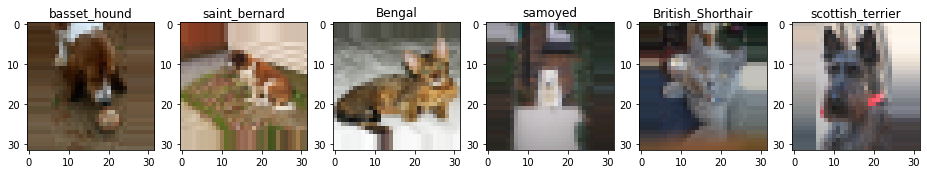

In [ ]:
# label_names = None # TODO the label names for your dataset (for example, in cifar-10 this would be ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog','horse', 'ship', 'truck'])

label_names = [None for _ in range(38)]
with open('./annotations/test.txt', 'r') as f:
    for line in f.readlines():
        splitted = line.split()
        label_idx = int(splitted[1])
        label_names[label_idx] = splitted[0][0: splitted[0].rindex('_')]

train_generator = DataGenerator( db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=32, shuffle=True) #TODO other params

batch_x, batch_y = train_generator[0]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(label_names[batch_y[i] + 1])
    axes[i].imshow(batch_x[i])
plt.show()


# CNN architecture

Write a simple tensorflow architecture for a convolutional neural network.
Use the [functional](!https://www.tensorflow.org/guide/keras/functional) api when writing the model.


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.activations import softmax
from tensorflow.keras import Model

In [ ]:
# The Keras functional API is a way to create models that are more flexible than the tf.keras.Sequential API. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

def res_block(inputs, filters):
    x = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = he_normal())(inputs)
    x = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
    return x + inputs

inputs = Input(shape=(32, 32, 3))
print(inputs.shape)
x = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = he_normal())(inputs)
x = res_block(x, 32)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
x = res_block(x, 64)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
x = res_block(x, 128)
x = GlobalAveragePooling2D()(x)
outputs = Dense(37, activation=softmax)(x)

(None, 32, 32, 3)


In [ ]:
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 32, 32, 32)   896         ['input_2[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_9[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_10[0][0]']              
                                                                                              

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)

In [ ]:
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=64, shuffle=True), epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
57/57 [==============================] - 69s 1s/step - loss: 3.5409 - accuracy: 0.0482
Epoch 2/10
57/57 [==============================] - 69s 1s/step - loss: 3.5317 - accuracy: 0.0518
Epoch 3/10
57/57 [==============================] - 69s 1s/step - loss: 3.5164 - accuracy: 0.0554
Epoch 4/10
57/57 [==============================] - 69s 1s/step - loss: 3.5050 - accuracy: 0.0581
Epoch 5/10
57/57 [==============================] - 69s 1s/step - loss: 3.4982 - accuracy: 0.0617
Epoch 6/10
57/57 [==============================] - 68s 1s/step - loss: 3.4658 - accuracy: 0.0702
Epoch 7/10
57/57 [==============================] - 68s 1s/step - loss: 3.4525 - accuracy: 0.0735
Epoch 8/10
57/57 [==============================] - 69s 1s/step - loss: 3.4263 - accuracy: 0.0762
Epoch 9/10
57/57 [==============================] - 69s 1s/step - loss: 3.3977 - accuracy: 0.0855
Epoch 10/10
57/57 [==============================] - 68s 1s/step - loss: 3.3870 - accuracy: 0.0866


In [ ]:
model.save('model_1')

INFO:tensorflow:Assets written to: model_1/assets


## Training and fine-tuning

Start by reading this blog [post](!http://karpathy.github.io/2019/04/25/recipe/), such that you can get an idea of the pipeline that you'll have to follow when training a model.

- Triple check that your data loading is correct. (Analyse your data.)
- Check that the setup is correct.
- Overfit a simple network.
- Add regularizations.
  - data augmentation
  - weight decay

Finetune the learning rate. Use learning rate decay; here in the [documentation](!https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule) you have an example on how you can use a learning rate scheduler in tensorflow.

You should have at least 7 different trainings. Plot all the training history.

__Save all your models and their training history!__ 


Create a google spreadsheet or a markdown table in this notebook, and report the configuration and the accuracy for all these trains. 

### Other useful videos (bias and variance, basic recipe for training a deep NN)
- https://www.youtube.com/watch?v=NUmbgp1h64E 
- https://www.youtube.com/watch?v=SjQyLhQIXSM&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2 
- https://www.youtube.com/watch?v=C1N_PDHuJ6Q&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=3 




In [ ]:
inputs = Input(shape=(32, 32, 3))
print(inputs.shape)
x = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = he_normal())(inputs)
x = res_block(x, 32)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
x = res_block(x, 64)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
x = res_block(x, 128)
x = GlobalAveragePooling2D()(x)
outputs = Dense(37, activation=softmax)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

(None, 32, 32, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_27 (Conv2D)             (None, 32, 32, 32)   896         ['input_4[0][0]']                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_27[0][0]']              
                                                                                                  
 conv2d_29 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_28[0][0]']              
                                                                          

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=20, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


28/28 [==============================] - 69s 2s/step - loss: 533.5193 - accuracy: 0.0287
Epoch 2/20
28/28 [==============================] - 68s 2s/step - loss: 3.6275 - accuracy: 0.0276
Epoch 3/20
28/28 [==============================] - 68s 2s/step - loss: 3.6162 - accuracy: 0.0246
Epoch 4/20
28/28 [==============================] - 67s 2s/step - loss: 3.6118 - accuracy: 0.0282
Epoch 5/20
28/28 [==============================] - 68s 2s/step - loss: 3.6072 - accuracy: 0.0301
Epoch 6/20
28/28 [==============================] - 68s 2s/step - loss: 3.6055 - accuracy: 0.0326
Epoch 7/20
28/28 [==============================] - 68s 2s/step - loss: 3.6010 - accuracy: 0.0310
Epoch 8/20
28/28 [==============================] - 69s 2s/step - loss: 3.5976 - accuracy: 0.0371
Epoch 9/20
28/28 [==============================] - 68s 2s/step - loss: 3.5927 - accuracy: 0.0321
Epoch 10/20
28/28 [==============================] - 67s 2s/step - loss: 3.5921 - accuracy: 0.0374
Epoch 11/20
28/28 [=========

INFO:tensorflow:Assets written to: model2/assets


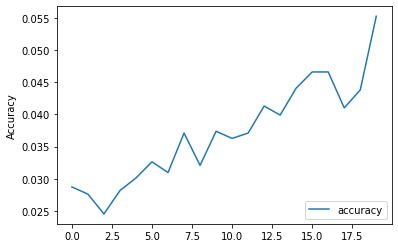

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('accuracy2', accuracy)
model.save('model2')

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


28/28 [==============================] - 70s 2s/step - loss: 4.7235 - accuracy: 0.0232
Epoch 2/10
28/28 [==============================] - 68s 2s/step - loss: 3.6347 - accuracy: 0.0212
Epoch 3/10
28/28 [==============================] - 68s 2s/step - loss: 3.6140 - accuracy: 0.0220
Epoch 4/10
28/28 [==============================] - 68s 2s/step - loss: 3.6127 - accuracy: 0.0251
Epoch 5/10
28/28 [==============================] - 69s 2s/step - loss: 3.7994 - accuracy: 0.0259
Epoch 6/10
28/28 [==============================] - 69s 2s/step - loss: 3.6429 - accuracy: 0.0246
Epoch 7/10
28/28 [==============================] - 68s 2s/step - loss: 3.6141 - accuracy: 0.0293
Epoch 8/10
28/28 [==============================] - 69s 2s/step - loss: 3.6123 - accuracy: 0.0276
Epoch 9/10
28/28 [==============================] - 69s 2s/step - loss: 3.6123 - accuracy: 0.0271
Epoch 10/10
28/28 [==============================] - 68s 2s/step - loss: 3.6122 - accuracy: 0.0273


INFO:tensorflow:Assets written to: model3/assets


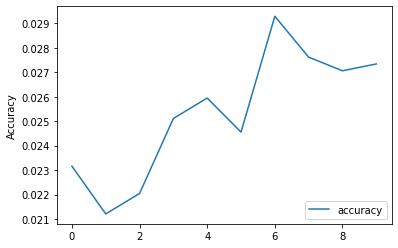

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('accuracy3', accuracy)
model.save('model3')

In [ ]:
from tensorflow.keras.optimizers.schedules import *

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


28/28 [==============================] - 67s 2s/step - loss: 20.2501 - accuracy: 0.0243
Epoch 2/10
28/28 [==============================] - 67s 2s/step - loss: 3.7701 - accuracy: 0.0268
Epoch 3/10
28/28 [==============================] - 67s 2s/step - loss: 3.6826 - accuracy: 0.0279
Epoch 4/10
28/28 [==============================] - 67s 2s/step - loss: 3.6591 - accuracy: 0.0268
Epoch 5/10
28/28 [==============================] - 67s 2s/step - loss: 3.6445 - accuracy: 0.0293
Epoch 6/10
28/28 [==============================] - 67s 2s/step - loss: 3.6354 - accuracy: 0.0318
Epoch 7/10
28/28 [==============================] - 67s 2s/step - loss: 3.6278 - accuracy: 0.0304
Epoch 8/10
28/28 [==============================] - 67s 2s/step - loss: 3.6233 - accuracy: 0.0318
Epoch 9/10
28/28 [==============================] - 67s 2s/step - loss: 3.6201 - accuracy: 0.0321
Epoch 10/10
28/28 [==============================] - 68s 2s/step - loss: 3.6171 - accuracy: 0.0326


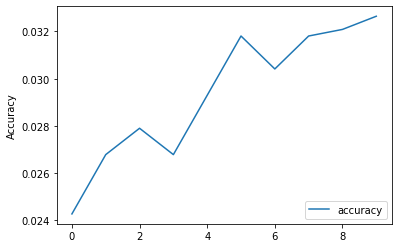

In [ ]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate

  def __call__(self, step):
     return self.initial_learning_rate / (step + 1)

opt = tf.keras.optimizers.Adam(learning_rate=MyLRSchedule(0.01))
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('accuracy4', accuracy)
# model.save('model4')

In [ ]:
# initial_learning_rate * decay_rate ^ (step / decay_steps)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


28/28 [==============================] - 68s 2s/step - loss: 4.0972 - accuracy: 0.0282
Epoch 2/10
28/28 [==============================] - 67s 2s/step - loss: 3.6173 - accuracy: 0.0268
Epoch 3/10
28/28 [==============================] - 67s 2s/step - loss: 3.6149 - accuracy: 0.0248
Epoch 4/10
28/28 [==============================] - 67s 2s/step - loss: 3.6121 - accuracy: 0.0248
Epoch 5/10
28/28 [==============================] - 67s 2s/step - loss: 3.7367 - accuracy: 0.0234
Epoch 6/10
28/28 [==============================] - 67s 2s/step - loss: 3.6186 - accuracy: 0.0223
Epoch 7/10
28/28 [==============================] - 67s 2s/step - loss: 3.6132 - accuracy: 0.0262
Epoch 8/10
28/28 [==============================] - 67s 2s/step - loss: 3.6162 - accuracy: 0.0220
Epoch 9/10
28/28 [==============================] - 67s 2s/step - loss: 3.6241 - accuracy: 0.0226
Epoch 10/10
28/28 [==============================] - 67s 2s/step - loss: 3.6118 - accuracy: 0.0246


INFO:tensorflow:Assets written to: model5/assets


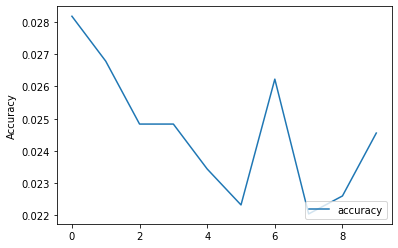

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('accuracy5', accuracy)
model.save('model5')

In [ ]:
"""
step = min(step, decay_steps)
cosine_decay = 0.5 * (1 + cos(pi * step / decay_steps))
decayed = (1 - alpha) * cosine_decay + alpha
return initial_learning_rate * decayed
"""
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


28/28 [==============================] - 68s 2s/step - loss: 21.4291 - accuracy: 0.0257
Epoch 2/10
28/28 [==============================] - 67s 2s/step - loss: 4.0454 - accuracy: 0.0229
Epoch 3/10
28/28 [==============================] - 67s 2s/step - loss: 3.6272 - accuracy: 0.0268
Epoch 4/10
28/28 [==============================] - 68s 2s/step - loss: 3.6188 - accuracy: 0.0234
Epoch 5/10
28/28 [==============================] - 68s 2s/step - loss: 3.6205 - accuracy: 0.0240
Epoch 6/10
28/28 [==============================] - 67s 2s/step - loss: 3.6199 - accuracy: 0.0229
Epoch 7/10
28/28 [==============================] - 67s 2s/step - loss: 3.6187 - accuracy: 0.0229
Epoch 8/10
28/28 [==============================] - 68s 2s/step - loss: 3.6206 - accuracy: 0.0201
Epoch 9/10
28/28 [==============================] - 68s 2s/step - loss: 3.6216 - accuracy: 0.0226
Epoch 10/10
28/28 [==============================] - 68s 2s/step - loss: 3.6216 - accuracy: 0.0209


INFO:tensorflow:Assets written to: model6/assets


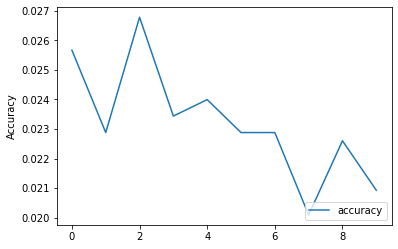

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('accuracy6', accuracy)
model.save('model6')

In [ ]:
# return initial_learning_rate / (1 + decay_rate * step / decay_step)
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=1.0,
    decay_rate=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


28/28 [==============================] - 68s 2s/step - loss: 3.6236 - accuracy: 0.0240
Epoch 2/10
28/28 [==============================] - 67s 2s/step - loss: 3.6145 - accuracy: 0.0276
Epoch 3/10
28/28 [==============================] - 67s 2s/step - loss: 3.6128 - accuracy: 0.0276
Epoch 4/10
28/28 [==============================] - 67s 2s/step - loss: 3.6120 - accuracy: 0.0276
Epoch 5/10
28/28 [==============================] - 67s 2s/step - loss: 3.6121 - accuracy: 0.0271
Epoch 6/10
28/28 [==============================] - 68s 2s/step - loss: 3.6118 - accuracy: 0.0271
Epoch 7/10
28/28 [==============================] - 67s 2s/step - loss: 3.6117 - accuracy: 0.0279
Epoch 8/10
28/28 [==============================] - 68s 2s/step - loss: 3.6116 - accuracy: 0.0271
Epoch 9/10
28/28 [==============================] - 67s 2s/step - loss: 3.6115 - accuracy: 0.0271
Epoch 10/10
28/28 [==============================] - 67s 2s/step - loss: 3.6114 - accuracy: 0.0273


INFO:tensorflow:Assets written to: model7/assets


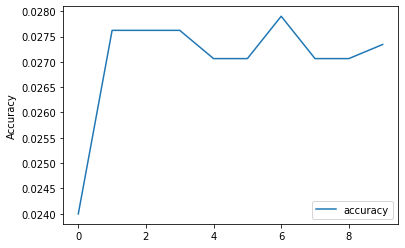

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('accuracy7', accuracy)
model.save('model7')

### **Extra credit**

Implement the learning rate scheduler described in the [paper](!https://arxiv.org/pdf/1608.03983.pdf) "SGDR: Stochastic gradient descent with warm restarts". You are mostly interested in Section 3 from the paper.

In [ ]:
# TODO optional extra credit assignment

## Ensembles
 
Pick your N (3 or 5) of the networks that you've trained and create an ensemble. The prediction of the ensemble is just the average of the predictions of the N networks.
 
Evaluate the ensemble (your accuracy should boost by at least 1.5%).


In [ ]:
ls

sample_data/


In [ ]:
# TODO your code here
# feed the images to the three networks, average the logits of the networks and 

# evaluate the ensemble
# from https://www.tensorflow.org/guide/keras/functional
def predict_ensemble(models, X):
    predictions = [models[0].predict(X)]
    for model in models[1:]:
        predictions.append(model.predict(X))

    
    predictions = np.array(predictions)
    avg = np.average(predictions, axis=0)
    return np.argmax(avg, axis=1)

In [ ]:
model1 = tf.keras.models.load_model('model_1')
model2 = tf.keras.models.load_model('model6')
model3 = tf.keras.models.load_model('model2')

In [ ]:
ensemble = [model1, model2, model3]
prediction = predict_ensemble(ensemble, batch_x[:3,:,:,:])
print(prediction)

[24  9 24]


# Transfer learning and fine-tuning
 
In the _tensorflow.keras.applications_ module you can find implementations of several well known CNN architectures (most of the models that we covered during the lecture), as well as the pretrained weights of these models on the ImageNet dataset. 
You can use this module to apply transfer learning and fine-tuning for your classification problem. [Here](!https://keras.io/api/applications/) you can find a comprehensive table with the size of the models, number of parameters, top-1 and top-5 accuracy on the ImageNet dataset.
 
When using deep neural networks, transfer learning is the norm, not the exception.  Transfer learning refers to the situation where what has been learned in one setting is used to improve generalization in another setting.
The transfer learning pipeline can be summarized as follows:
- get the weights of a model trained on similar classification problem (for which more training data is available);
- remove the final classification layer;
- freeze the weights (don't update them during the training process); these layers would be used as a feature extractor;
- add a/some trainable layers over the frozen layers. They will learn how the extracted features can be used to distinguish between the classes of your classification problem.
- train these new layers on your dataset.
 
Next, you can also use fine-tuning. During fine-tuning you will unfreeze the model (or a larger part of the model), and train it on the new data with a very low learning rate.
 
Follow this [tutorial](!https://keras.io/guides/transfer_learning/) to solve this exercise.
 
When following the tutorial
- pay attention to the discussion about the BatchNormalization layers;
- you can skip the section "Transfer learning & fine-tuning with a custom training loop", we'll cover this in the next laboratory;
- pay attention to the loss that you will be using when training your model. In the tutorial the loss is the binary cross entropy loss which is suitable for binary classification problems. If your problem is multi-class you should use the categorical cross entropy loss.
- use the pre-processing required by the network architecture that you chose.
 
To sum up, pick a neural network architecture from the _tensorflow.keras.applications_ module and use transfer learning and fine tuning to train it to classify the images from your dataset (you should use the custom DataGenerator that you wrote for this). 
 Briefly describe the key features of the neural network architecture that you chose and why you chose it.
 
Apply transfer learning (with at least one config for the hyperparameters) and report the performance. Apply fine-tuning  (with at least one config for the hyperparameters) and report the performance.
Finally, plot the performance of the model when you used only transfer learning and the performance of the model when you also used fine-tuning on the same plot.
 
I chose the architecture <font color='red'> Xception </font> , because it is the first described in keras applications available models and I found online suport in terms of implementing transfer learning using this model.
The key features of this architecture are
- Compared with conventional convolution, we do not need to perform convolution across all channels. That means the number of connections are fewer and the model is lighter.
- Xception outperforms VGGNet, ResNet, and Inception-v3.
- Performance gains due to a more efficient use of
model parameters
 
How does the performance of this fine-tuned model compare to the performance of the network that you trained from scratch?
 




In [ ]:
from tensorflow.keras.applications import Xception

In [ ]:
# TODO your transfer-learning and fine-tuning step

base_model = tf.keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)

base_model.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

outputs = tf.keras.layers.Dense(37)(x)
model = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (150, 150, 3), num_classes = 37, batch_size=64, shuffle=True), epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


Epoch 1/10
57/57 [==============================] - 50s 820ms/step - loss: 3.6122 - accuracy: 0.0175
Epoch 2/10
57/57 [==============================] - 47s 819ms/step - loss: 3.6081 - accuracy: 0.0225
Epoch 3/10
57/57 [==============================] - 47s 826ms/step - loss: 3.6065 - accuracy: 0.0236
Epoch 4/10
57/57 [==============================] - 47s 819ms/step - loss: 3.6053 - accuracy: 0.0252
Epoch 5/10
57/57 [==============================] - 46s 809ms/step - loss: 3.6045 - accuracy: 0.0238
Epoch 6/10
57/57 [==============================] - 46s 806ms/step - loss: 3.6038 - accuracy: 0.0247
Epoch 7/10
57/57 [==============================] - 46s 811ms/step - loss: 3.6033 - accuracy: 0.0271
Epoch 8/10
57/57 [==============================] - 47s 824ms/step - loss: 3.6027 - accuracy: 0.0291
Epoch 9/10
57/57 [==============================] - 47s 814ms/step - loss: 3.6024 - accuracy: 0.0258
Epoch 10/10
57/57 [==============================] - 46s 809ms/step - loss: 3.6019 - accura

INFO:tensorflow:Assets written to: model8/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


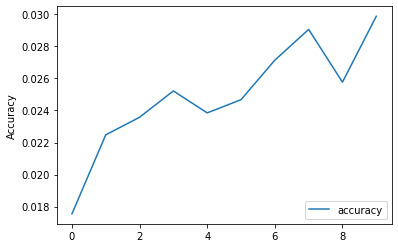

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('accuracy8', accuracy)
model.save('model8')

In [ ]:
# Unfreeze the base model
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (150, 150, 3), num_classes = 37, batch_size=64, shuffle=True), epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
57/57 [==============================] - 216s 4s/step - loss: 3.6071 - accuracy: 0.0293
Epoch 2/10
57/57 [==============================] - 207s 4s/step - loss: 3.6032 - accuracy: 0.0285
Epoch 3/10
57/57 [==============================] - 206s 4s/step - loss: 3.6034 - accuracy: 0.0296
Epoch 4/10
57/57 [==============================] - 205s 4s/step - loss: 3.6018 - accuracy: 0.0293
Epoch 5/10
57/57 [==============================] - 204s 4s/step - loss: 3.5970 - accuracy: 0.0310
Epoch 6/10
57/57 [==============================] - 203s 4s/step - loss: 3.5938 - accuracy: 0.0307
Epoch 7/10
57/57 [==============================] - 202s 4s/step - loss: 3.5904 - accuracy: 0.0315
Epoch 8/10
57/57 [==============================] - 201s 4s/step - loss: 3.5876 - accuracy: 0.0302
Epoch 9/10
57/57 [==============================] - 200s 3s/step - loss: 3.5835 - accuracy: 0.0315
Epoch 10/10
57/57 [==============================] - 199s 3s/step - loss: 3.5845 - accuracy: 0.0312


INFO:tensorflow:Assets written to: model10/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


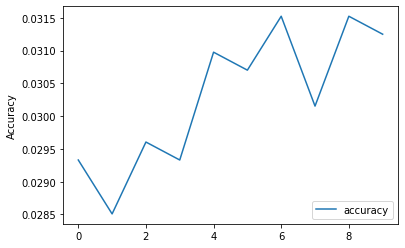

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('accuracy10', accuracy)
model.save('model10')